<a href="https://colab.research.google.com/github/simejisan/DIP20/blob/main/SIFT-Image-Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Xử lý ảnh mid-term**

---
> Sinh viên: Lê Minh Tâm - 17021332

>[Giải thích chi tiết về thuật toán xin xem ở link bài báo cáo version 2.0](https://drive.google.com/file/d/1zrZg41Ihz8cXzWIxRQYXALb0Ly0sGmVS/view?usp=sharing) 

---

In [ ]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [ ]:
import cv2
import numpy as np
import json
import glob
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
import os
import time
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

Preprocess Image


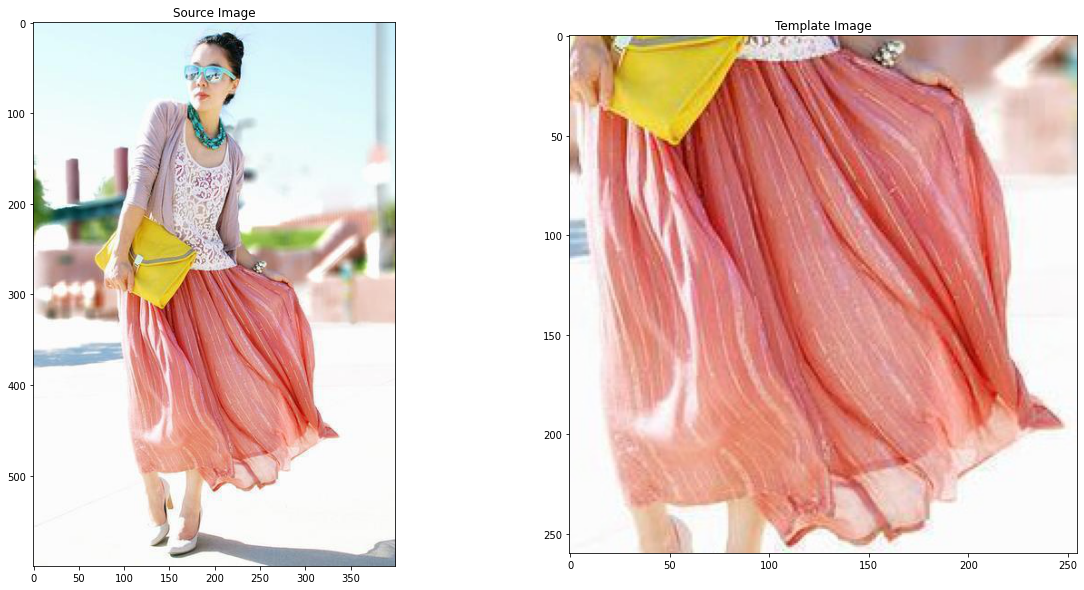

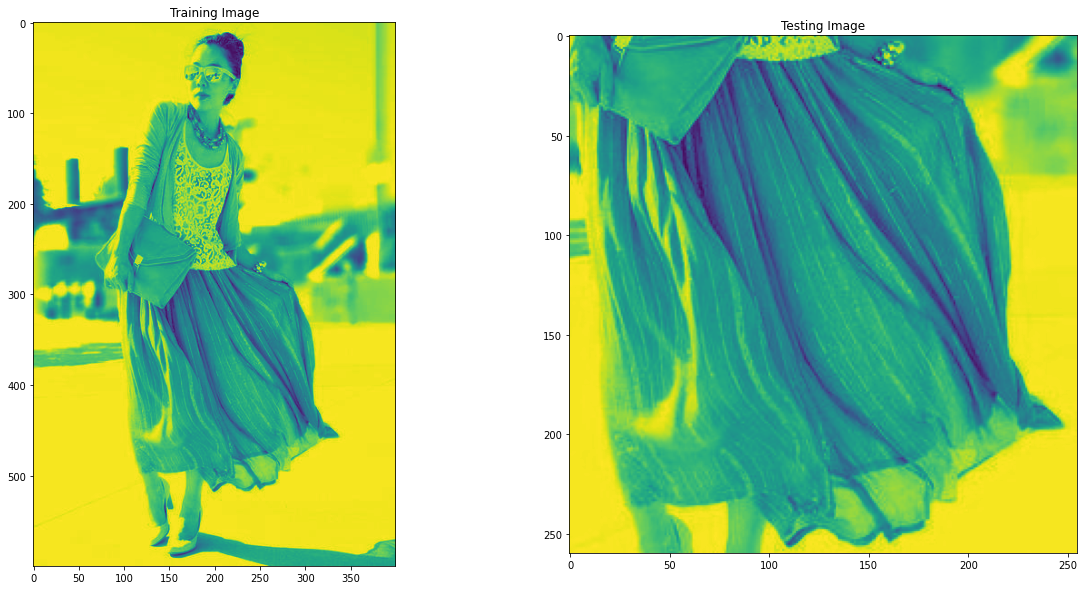

In [ ]:
#read image
img = plt.imread("1.jpg")
img2 = img.copy()
image_small = img.copy()

template = plt.imread("temp.jpg")
template = cv2.normalize(template, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
_,w, h = template.shape[::-1]

# num_rows, num_cols = template.shape[:2]
# rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
# test_image = cv2.warpAffine(template, rotation_matrix, (num_cols, num_rows))

def gamma_correction(img, correction):
  invGamma = 1.0/correction
  img = cv2.pow(img, invGamma)
  return np.uint8(img*255)

train_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
test_gray = cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)

test_gray_n = gamma_correction(test_gray, 0.5)
train_gray_n = gamma_correction(train_gray,0.5)

fx, plots = plt.subplots(1,2, figsize=(20,10))
plots[0].set_title("Source Image")
plots[0].imshow(img)

plots[1].set_title("Template Image")
plots[1].imshow(template)

# fx, plots = plt.subplots(1,2, figsize=(20,10))
# plots[0].set_title("Training Image")
# plots[0].imshow(train_gray)

# plots[1].set_title("Testing Image")
# plots[1].imshow(test_gray)

Scale, Rotate Source Image

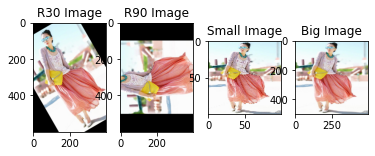

In [ ]:
 #resize image
 num_rows, num_cols = img.shape[:2]
 rotation_matrix0 = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
 rotation_matrix1 = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 90, 1)

 r30_image = cv2.warpAffine(img, rotation_matrix0, (num_cols, num_rows))
 r90_image = cv2.warpAffine(img, rotation_matrix1, (num_cols, num_rows))

 image_small = cv2.resize (img, (100,100));
 image_large = cv2.resize (img, (500,500));


 fx, plots = plt.subplots(1,4)
 plots[0].set_title("R30 Image")
 plots[0].imshow(r30_image)
 plots[1].set_title("R90 Image")
 plots[1].imshow(r90_image)
 plots[2].set_title("Small Image")
 plots[2].imshow(image_small)
 plots[3].set_title("Big Image")
 plots[3].imshow(image_large)

  #image_small = cv2.resize((round(img.size[0]*0.5), round(img.size[1]*0.5))
# cv2.waitKey(30)
# cv2.destroyAllWindows()

Compute Sift Features & Draw Keypoint 

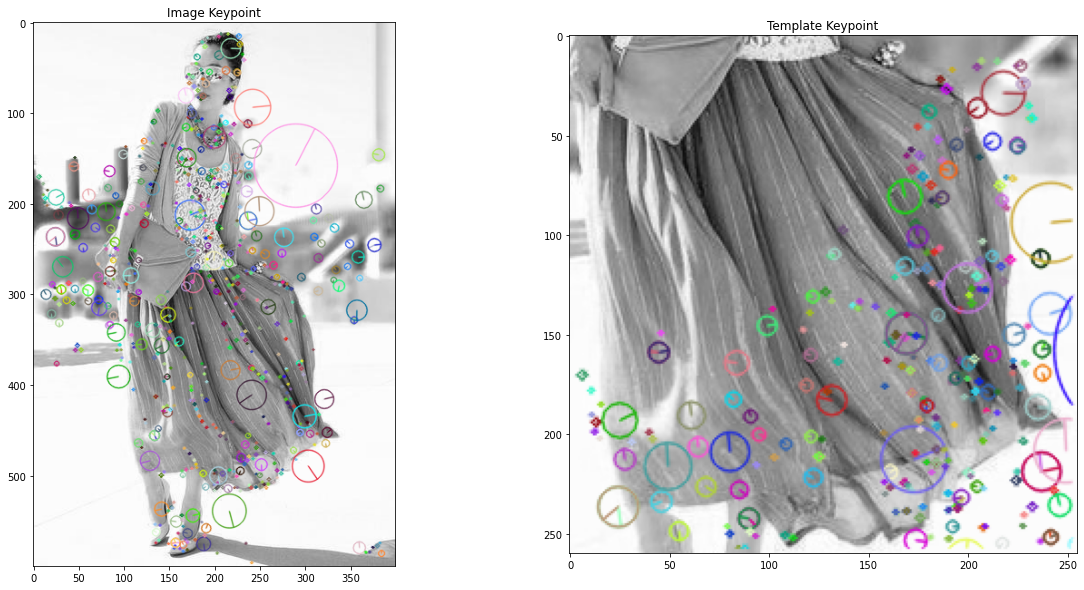

In [ ]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img,None)
kp2, des2 = sift.detectAndCompute(template,None)
img_kp =cv2.drawKeypoints(train_gray,kp1,outImage = None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
temp_kp =cv2.drawKeypoints(test_gray,kp1,outImage = None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1,2, figsize=(20,10))
plots[0].set_title("Image Keypoint")
plots[0].imshow(img_kp)
plots[1].set_title("Template Keypoint")
plots[1].imshow(temp_kp)

Match keypoint

In [ ]:
# Brute Force Matcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# apply ratio test
good = []
c = 0
for m,n in matches:
    if m.distance < 0.65*n.distance:
        good.append([m])
        c+=1

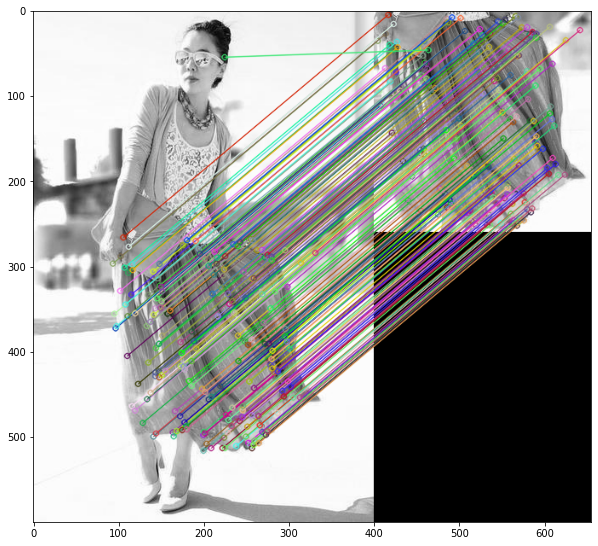

In [ ]:
start_time = time.perf_counter()
# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(8);
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(train_gray,kp1,test_gray,kp2,good,None,flags=2)
Total_Execution_Time = time.perf_counter() - start_time
# display best matching
plt.figure(figsize=(10,10))
plt.imshow(img3)
plt.show()

Calculate accuracy of matched keypoint

In [ ]:
# Matches' similarity
number_keypoints = 0
if len(kp1) <= len(kp2) :
  number_keypoints = len(kp1)
else:
  number_keypoints = len(kp2)
print ("Keypoints source image: " + str(len(kp1)))
print ("Keypoints template image " + str(len(kp2)))

Keypoints source image: 712
Keypoints template image 289


In [ ]:
print("Good matches: ", len(good))
print ("Features Matching Percentage: ", len(good)/len(kp2)*100, "%")

Good matches:  210
Features Matching Percentage:  72.66435986159169 %


Template Matching Sift Features




In [ ]:
img2 = img.copy()

res = cv2.matchTemplate(train_gray, test_gray, cv2.TM_SQDIFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)


min_thresh = (min_val)*1.1
match_locations = np.where(res<=min_thresh)

# draw bounding box 
for (x, y) in zip(match_locations[1], match_locations[0]):
    cv2.rectangle(img2, (x, y), (x+w, y+h), [0,0,255], 2)

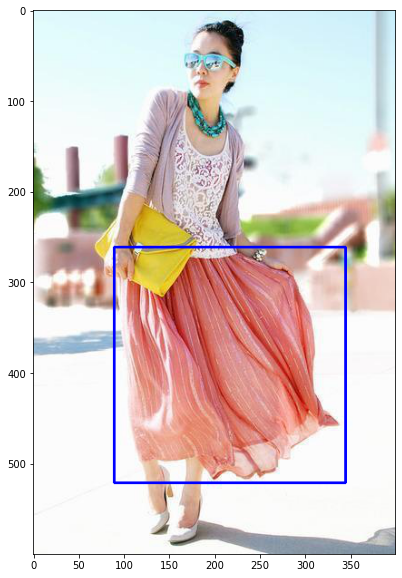

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img2)
plt.show()

In [ ]:
#Total_Execution_Time
print(Total_Execution_Time, "seconds")

0.011539601999970728 seconds


K-means Bounding Box

In [ ]:
# #resize image
# input_folder = "images"
# os.mkdir ("resized_images")
# i = 0
# for img in glob.glob("images/*.jpg"):
#   image = cv2.imread(img)
#   resized_img = cv2.resize(image, (200,200))
#   cv2.imwrite((data_path + "resized_images/images%0i.jpg") %i, resized_img)
#   i +=1
#   cv2_imshow(cv2.imread('image', resized_img))
#   cv2.waitKey(30)
# cv2.destroyAllWindows()